__Project:__ Intent Recognition <br> 
__Sub-prj:__ Parametric Evaluation - _number of labels & data fraction_ <br>
__Experm:__  Distilbert-base-uncased <br>
__Contact:__ Amir Hossini <br>
__Dev Dat:__ Oct 13, 2021 <br>

#### Libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import transformers
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
from IPython.display import clear_output

print(f"Tensorflow version: {tf.__version__}")
print(f"Transformers version: {transformers.__version__}")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensorflow version: 2.5.0
Transformers version: 4.11.3
Num GPUs Available:  1


#### I/O Files & Params

In [6]:
fl_train = '../datasets/banking77/train.csv'
fl_test  = '../datasets/banking77/test.csv'

experiment_grid = {
    'n_labels'  : [3, 10, 20, 77],
    'train_frac': [1., 0.5, 0.1]
}

seed = 42

#### Functions

In [15]:
def select_data(train, test, col_label, n_labels=None, train_frac=None):
    if n_labels is None:
        n_labels = len(train.loc[:,col_label].unique())
    if train_frac is None:
        train_frac = 1
        
    select_labels = np.array(train.loc[:,col_label].value_counts()[0:n_labels].index)
    select_train  = train.loc[train[col_label].isin(select_labels),:].reset_index(drop=True)
    n_data_train  = len(select_train)
    n_data_select = int(n_data_train * train_frac)
    indx_select   = np.random.choice(range(n_data_train),n_data_select)
    select_train  = select_train.iloc[indx_select,:]
    select_train  = select_train.reset_index(drop=True)
    select_test   = test.loc[test[col_label].isin(select_labels),:].reset_index(drop=True)
    n_data_test   = len(select_test)
    indx_test     = np.random.choice(range(n_data_test),n_data_test)
    select_test   = select_test.iloc[indx_test,:]
    select_test   = select_test.reset_index(drop=True)
    return select_train, select_test

def factorize_data(train, test, col_label,return_keys=False):
    train_labels, levels = pd.factorize(train.loc[:,col_label])
    categs = pd.concat([train.loc[:,col_label],pd.Series(train_labels)],axis=1).groupby(col_label).mean().index
    labels = pd.concat([train.loc[:,col_label],pd.Series(train_labels)],axis=1).groupby(col_label).mean().values.T[0]
    label_keys=dict(zip(categs,labels))
    test_labels = test.loc[:,col_label].map(lambda x: label_keys[x])
    train.loc[:,col_label]=train_labels
    test.loc[:,col_label]=test_labels
    if return_keys:
        return train, test, label_keys
    else:
        return train, test
    
def tokenize_encode_data(train,test,col_text,col_label,checkpoint='distilbert-base-uncased',
                         truncation_flag=True, padding_flag=True, return_tensors_opt='tf'):
    train_sentences = list(train.loc[:,col_text])
    test_sentences  = list(test.loc[:,col_text])
    train_labels    = list(train.loc[:,col_label])
    test_labels     = list(test.loc[:,col_label])
    tokenizer       = AutoTokenizer.from_pretrained(checkpoint)
    train_encodings = tokenizer(train_sentences, truncation=truncation_flag,
                                padding=padding_flag, return_tensors=return_tensors_opt)
    test_encodings  = tokenizer(test_sentences, truncation=truncation_flag,
                                padding=padding_flag, return_tensors=return_tensors_opt)
    train_dataset   = tf.data.Dataset.from_tensor_slices((dict(train_encodings),train_labels))
    test_dataset    = tf.data.Dataset.from_tensor_slices((dict(test_encodings),test_labels))
    return train_dataset, test_dataset 

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def transformer_model(train_dataset,test_dataset,n_labels,verbose=3,lr=5e-5,
                      epochs=10,batch_size=64,checkpoint='distilbert-base-uncased'):
    model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=n_labels)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss=SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
    history = model.fit(train_dataset.batch(batch_size),epochs=epochs,batch_size=batch_size,
          validation_data=test_dataset.batch(batch_size))
    return history, model

size of training dataset: 176
size of testing dataset: 400


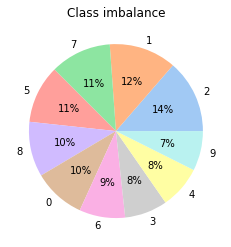

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_139']
You should probably TRAIN this model on a down-stream task to be able to use 

Epoch 1/30
3/3 [==============================] - 7s 1s/step - loss: 2.2969 - accuracy: 0.1193 - val_loss: 2.2847 - val_accuracy: 0.1325
Epoch 2/30
3/3 [==============================] - 2s 659ms/step - loss: 2.2542 - accuracy: 0.1875 - val_loss: 2.2402 - val_accuracy: 0.1325
Epoch 3/30
3/3 [==============================] - 2s 670ms/step - loss: 2.1752 - accuracy: 0.2273 - val_loss: 2.1627 - val_accuracy: 0.2750
Epoch 4/30
3/3 [==============================] - 2s 661ms/step - loss: 2.0685 - accuracy: 0.3920 - val_loss: 2.0563 - val_accuracy: 0.3625
Epoch 5/30
3/3 [==============================] - 2s 793ms/step - loss: 1.9206 - accuracy: 0.6307 - val_loss: 1.9082 - val_accuracy: 0.5075
Epoch 6/30
3/3 [==============================] - 2s 669ms/step - loss: 1.7507 - accuracy: 0.7841 - val_loss: 1.7439 - val_accuracy: 0.6000
Epoch 7/30
3/3 [==============================] - 2s 660ms/step - loss: 1.5651 - accuracy: 0.8523 - val_loss: 1.5782 - val_accuracy: 0.6775
Epoch 8/30
3/3 [=======

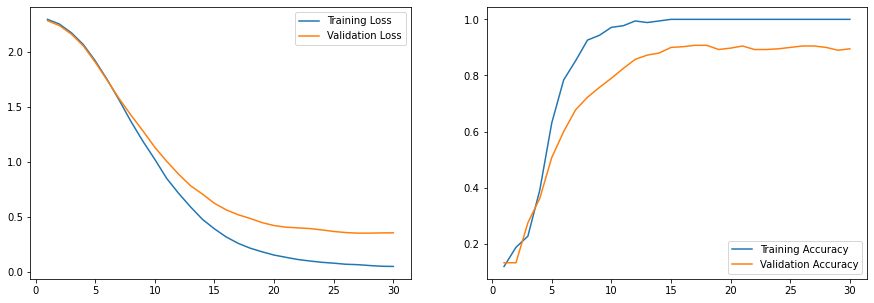

In [17]:
n_labels = 10
train_frac = 0.1

np.random.seed(seed)
train = pd.read_csv(fl_train)
test  = pd.read_csv(fl_test)

train, test = select_data(train, test, 'category', n_labels, train_frac)
train, test = factorize_data(train, test, 'category')

print(f'size of training dataset: {len(train)}')
print(f'size of testing dataset: {len(test)}')

colors = sns.color_palette('pastel')[0:n_labels]
_ = plt.pie(list(train['category'].value_counts()), 
            labels = list(train['category'].value_counts().index), 
            colors = colors, 
            autopct='%.0f%%')
_ = plt.title('Class imbalance')
_ = plt.show()

train_dataset, test_dataset = tokenize_encode_data(train,test,'text','category',checkpoint='distilbert-base-uncased')
history, fitted_model       = transformer_model(train_dataset,test_dataset,n_labels,epochs=30)

fig, axes   = plt.subplots(1,2,figsize=(15,5))
epoch_range = np.arange(1,len(history.history['loss'])+1)
axes[0]   = sns.lineplot(ax=axes[0],x=epoch_range,y=history.history['loss'],label='Training Loss')
axes[0]   = sns.lineplot(ax=axes[0],x=epoch_range,y=history.history['val_loss'],label='Validation Loss')
axes[1]   = sns.lineplot(ax=axes[1],x=epoch_range,y=history.history['accuracy'],label='Training Accuracy')
axes[1]   = sns.lineplot(ax=axes[1],x=epoch_range,y=history.history['val_accuracy'],label='Validation Accuracy')

In [ ]:
"""Bin
# axes[1,0]   = sns.lineplot(ax=axes[1,0],x=epoch_range,y=history.history['precision_m'],label='Training Precision')
# axes[1,0]   = sns.lineplot(ax=axes[1,0],x=epoch_range,y=history.history['val_precision_m'],label='Validation Precision')
# axes[1,1]   = sns.lineplot(ax=axes[1,1],x=epoch_range,y=history.history['recall_m'],label='Training Recall')
# axes[1,1]   = sns.lineplot(ax=axes[1,1],x=epoch_range,y=history.history['val_recall_m'],label='Validation Recall')

# axes[0,1].set(ylim=(0,1)); axes[1,0].set(ylim=(0,1)); axes[1,1].set(ylim=(0,1))
"""